<a href="https://colab.research.google.com/github/FarizKesten/CppPackagingExamples/blob/main/TestSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# useful segmentation model libraries
!pip install -q segmentation-models-pytorch > /dev/null 2>&1
!pip install -q PyWavelets opencv-python > /dev/null 2>&1

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp


import matplotlib.pyplot as plt
from tqdm import tqdm

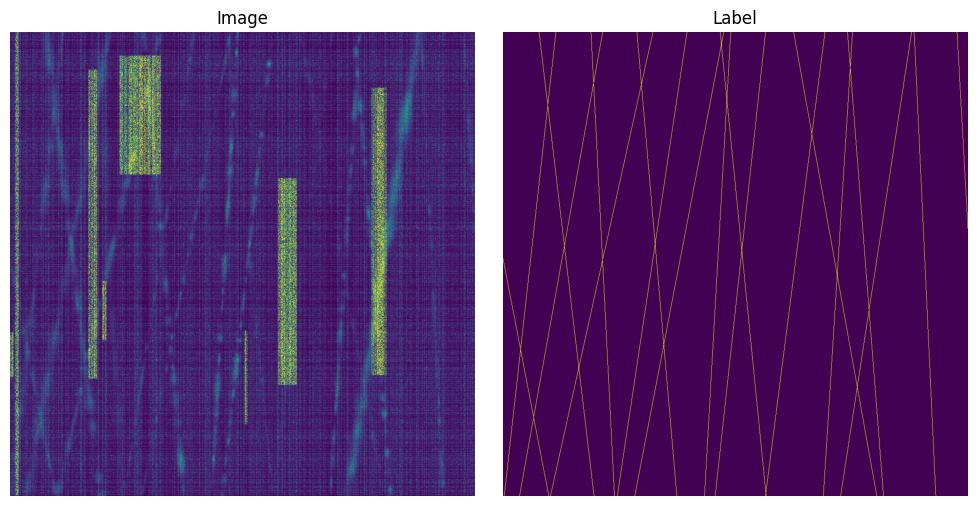

In [3]:
# try reading 1 image

import matplotlib.pyplot as plt

image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)

image_size = int(np.sqrt(len(image)))

image_reshaped = image.reshape((image_size, image_size))
labelimg_reshaped = label.reshape((image_size, image_size))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_reshaped)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(labelimg_reshaped)
axes[1].set_title('Label')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


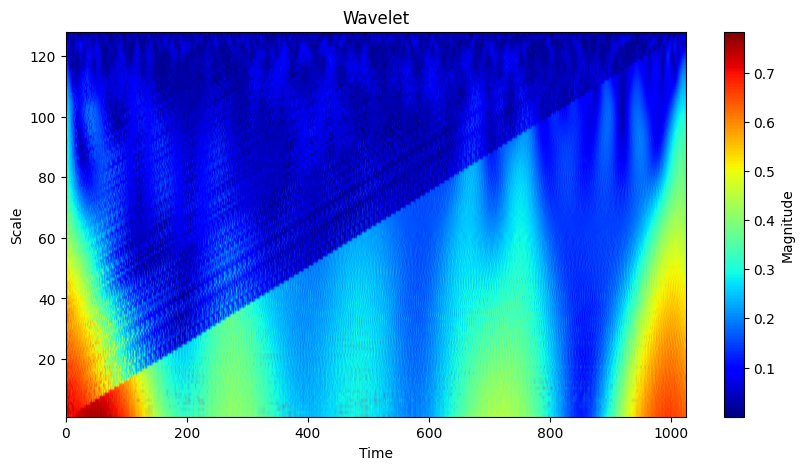

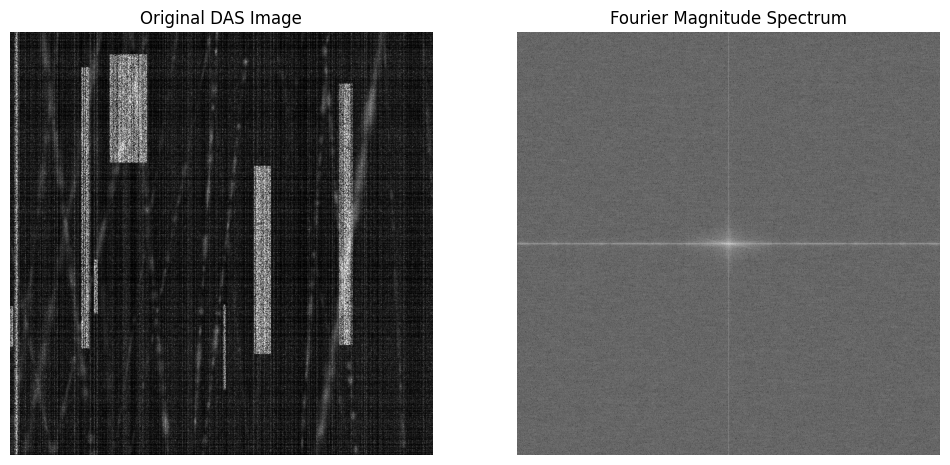

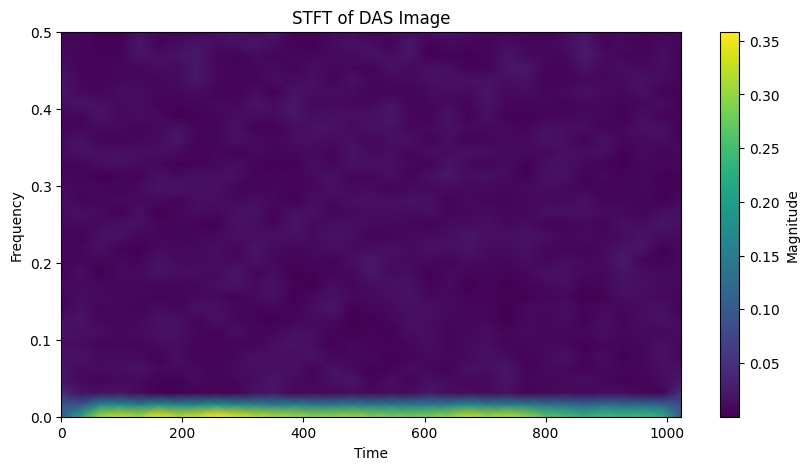

In [ ]:
import pywt
import pywt.data


wavelet = 'cmor'

coeffs, frequencies = pywt.cwt(image_reshaped.mean(axis=1), scales=np.arange(1, 128), wavelet=wavelet)

# Plot Wavelet Transform
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(coeffs), aspect='auto', cmap='jet', extent=[0, image_reshaped.shape[1], 1, 128])
plt.colorbar(label="Magnitude")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.title("Wavelet")
plt.show()

# Apply 2D Fourier Transform
fft_image = np.fft.fft2(image_reshaped)
fft_shift = np.fft.fftshift(fft_image)  # Shift zero frequency to the center

# Compute Magnitude Spectrum
magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1)  # Log for better visibility

# Display Original Image and Frequency Spectrum
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_reshaped, cmap="gray")
axes[0].set_title("Original DAS Image")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Fourier Magnitude Spectrum")
axes[1].axis("off")

plt.show()


import scipy.signal as signal

# Parameters
nperseg = 64  # Window size (adjust based on DAS data)

# Compute STFT
frequencies, times, Zxx = signal.stft(image_reshaped.mean(axis=1), fs=1.0, nperseg=nperseg)

# Plot STFT Magnitude
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.colorbar(label="Magnitude")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("STFT of DAS Image")
plt.show()



In [5]:
# TEST: get min max and statistic of labelimg_reshaped

print(np.min(labelimg_reshaped))
print(np.max(labelimg_reshaped))
print(np.median(labelimg_reshaped))
print(np.mean(labelimg_reshaped))
print(np.std(labelimg_reshaped))

0.0
1.0
0.0
0.01745987
0.13097715


In [ ]:
# Create a model for the segmentation

# (1): use UNet

models = {
    "Unet": smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "DeepLabV3Plus": smp.DeepLabV3Plus(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "FPN": smp.FPN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "PAN": smp.PAN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "PSPNet": smp.PSPNet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

}


# printing all models that are used
for key, model in models.items():
  print(key)


Unet
DeepLabV3Plus
FPN
PAN
PSPNet


# Load & Transform Dataset


In [7]:
from sklearn.model_selection import train_test_split

file_names = os.listdir('/content/drive/MyDrive/ml_data/unet/cnn1/data/img')
train_files, rest_files = train_test_split(file_names, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(rest_files, test_size=0.5, random_state=42)

print(len(train_files))
print(len(val_files))
print(len(test_files))

140
30
30


In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random



class SegmentationDataset(Dataset):
  def __init__(self, image_path, label_path, image_names, transform=False):
    self.image_path = image_path
    self.label_path = label_path
    self.transform = transform

    self.image_names = image_names

  def __len__(self):
    return len(self.image_names)


  def trans(self, image, label):
    '''
    add some randomness on the training dataset
    '''

    if random.random() > 0.5:
      image = F.hflip(image)
      label = F.hflip(label)

    if random.random() > 0.5:
      image = F.vflip(image)
      label = F.vflip(label)

    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = F.rotate(image, angle)
      label = F.rotate(label, angle)

    return image, label


  def __getitem__(self, index):
    '''
    get both images and labels. in case a transform flag is set, apply a rando
    '''
    image_id = self.image_names[index]

    image = np.fromfile(os.path.join(self.image_path, image_id), dtype=np.single)
    label = np.fromfile(os.path.join(self.label_path, image_id), dtype=np.single)

    image_size = int(np.sqrt(len(image)))

    image = image.reshape((image_size, image_size))
    label = label.reshape((image_size, image_size))

    image = F.to_pil_image(image)
    label = F.to_pil_image(label)

    if self.transform:
      image, label = self.trans(image, label)


    # convert to tensors
    image_tensor = T.ToTensor()(image)
    label_tensor = T.ToTensor()(label)

    return image_tensor, label_tensor



In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

#Instantiate the dataset

train_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=train_files,
    transform=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=val_files,
    transform=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=test_files,
    transform=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [ ]:
# Training


def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0
  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)


    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
  return running_loss / len(loader)




In [11]:
NUMS_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for key, model in models.items():
  best_val_loss = float('inf')

  model_dir = os.makedirs(
      os.path.join('/content/drive/MyDrive/ml_data/unet/cnn1/data/mdls/', key),
      exist_ok=True
  )

  model.to(device)

  for epoch in range(NUMS_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), model_dir)
      print(f"New best model {key} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    print(f"Epoch {epoch+1}/{NUMS_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



AttributeError: expected 'f' to be string, path, or a file-like object with a 'write' attribute

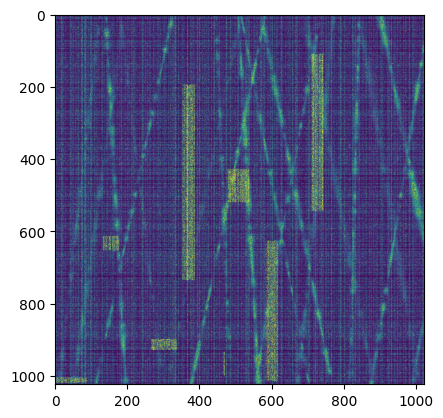

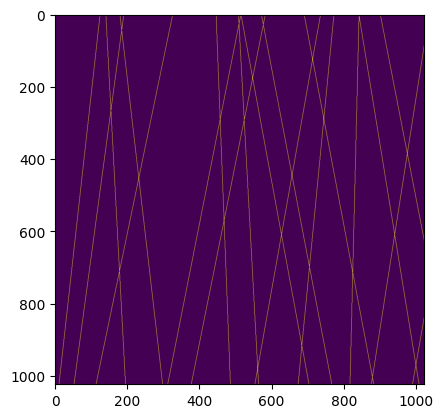

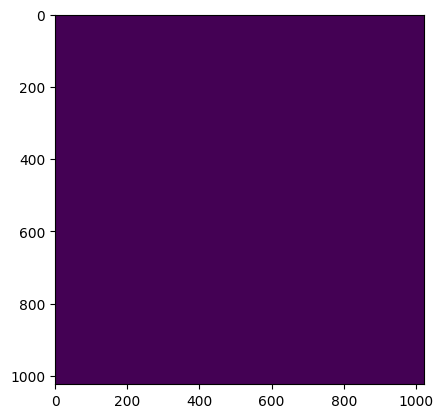

In [ ]:

def preproc_image(image_path, device):
  image = np.fromfile(image_path, dtype=np.single)
  image_size = int(np.sqrt(len(image)))
  image = image.reshape((image_size, image_size))

  transform = T.Compose([
      T.ToPILImage(),
      #T.Resize((256,256)),
      T.ToTensor(),
  ])

  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)
  return image

for key, model in models.items():
  model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/ml_data/unet/cnn1/data/mdls/', key, 'best_model.pth')))
model.eval()

with torch.no_grad():
  for images, labels in test_loader:
    plt.imshow(images[0].squeeze())
    plt.show()
    plt.imshow(labels[0].squeeze())
    plt.show()

    images = images.to(device)
    labels = labels.to(device)

    #output_logits = model(preproc_image('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat', device))
    output_logits = model(images)
    output_logits = output_logits.cpu()
    output_logits = output_logits.squeeze(0).squeeze()
    output_logits = output_logits.numpy()
    output_logits = np.where(output_logits > 0.5, 1, 0)
    plt.imshow(output_logits)
    plt.show()

    #image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
    #image_reshaped = image.reshape((image_size, image_size))

    label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)
    labelimg_reshaped = label.reshape((image_size, image_size))
    break

